In [1]:
import torch, time, pickle,os
import torch_geometric as tg
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp
import networkx as nx

In [2]:
def convert(d,p):
    dfin=[]
    if len(p)!=len(np.unique(p)):
        print('Wrong order of prog/desc')
    else:
        no=d[0]
        for desc in d:
            if desc==no:
                dfin.append(0)
            else:
                dfin.append(p.index(desc)+1)
    return dfin, np.arange(1, 1+len(p))

In [3]:
def graph_variance(tcols=[0,2,4,5,6,7,8,10,28], target=8, save=False, lim=10.5, case='test', transform='quantile', maxs=[1,1,1]):
    dat=[]
    tcols=np.array(tcols)
    raw_path='~/../../../tigress/mcranmer/merger_trees/isotrees/'
    target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
    transform_path=f'../../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
    scaler=pickle.load(open(transform_path, 'rb'))
    global not_include
    not_include=np.array([0,1,0,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]) 
    is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]
    is_cat=np.array([bool(i) for i in is_cat])
    icols=np.array([1,3])
    load_cols=np.sort(np.concatenate([tcols,icols]))
    not_include=not_include[load_cols]
    for i in range(0, maxs[0]):
        for j in range(0,maxs[1]):
            for k in range(0, maxs[2]):
                
                start=time.time()
                
                print(f'Loading isotree {i}_{j}_{k}')

                pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
                print(f'isotree {i}_{j}_{k} loaded, restructuring')

                raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
                del pd1

                trees=raw[raw.isna()['desc_id(3)']] 
                halos=raw[~raw.isna()['desc_id(3)']]
                del raw

                mask=halos.dtypes.values[1:]=='O'

                f,it="float64", "int64"
                map1=[]
                map2=[]
                q=0
                for l in load_cols:
                    q+=1
                    if l<25:
                        map1.append(l)
                        map2.append(q)
                map1=np.array(map1)
                map2=np.array(map2)

                castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

                castto=castto[map1]
                dicts = {}
                keys = halos.columns[map2]
                for d, key in enumerate(keys):
                        dicts[key] = castto[d]

                halos=halos.astype(dicts)

                ## initial scaling
                hard=[0,2,15]
                def logit(x):
                    return np.log10((x+0.001)/(1.01-x))
                ##logit transform the hards
                for h in hard:
                    if h in tcols:
                        h1=np.where(load_cols==h)[0][0]+1
                        halos[halos.columns[h1]]=logit(halos[halos.columns[h1]])

                log=[10,38, 39, 40, 41, 42]

                def logt(x):
                    return np.log10(x+1)
                for l in log:
                    if l in tcols:
                        l1=np.where(load_cols==l)[0][0]+1
                        halos[halos.columns[l1]]=logt(halos[halos.columns[l1]])

                scale_cols=np.array(tcols[~is_cat[tcols]])

                print(f'Splitting to tree and scaling')
                spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
                splits=[]
                for s in spli:
                    if s[0,np.where(load_cols==10)[0][0]]>lim:
                        splits.append(s)
                splits=np.array(splits, dtype=object)
                split=[]
                idx=[]
                ## split to only roots (tree[:,4]=0), mergers (tree[:,4]>1) or the final halo (tree[:,3] == -1)
                for m, tree in enumerate(splits):
                    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
                    if len(s)>20000:
                        print(len(s))
                    else:
                        for n in scale_cols:
                            n1=np.where(load_cols==n)[0][0]
                            s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1]))

                        split.append(s)
                        idx.append(m)
                split=np.array(split, dtype=object)
                print('Split done')

                halwgal=split
                hraw=np.array(splits[idx], dtype=object)
                hals=[]
                out=[]
                pr,de=[],[]
                discards=[]
                print('Making merger tree')
                for n in tqdm(range(len(halwgal))):
                    h=halwgal[n]
                    roots=h[h[:,4]==0]
                    mergers=h[h[:,4]>1]
                    final=h[h[:,3]==-1]
                    pro, des=[],[]
                    discarded=[]
                    for mid in mergers[:,1]:
                        k=1
                        descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])] ##descendant ID of raw where the id of the merger is
                        while descid not in mergers[:,1] and descid!=-1: 
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
                        pro.append(mid)
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
                        discarded.append(1/k)

                    for r in roots:
                        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
                        k=1
                        while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
                        pro.append(r[1])
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    discards.append(np.array(discarded))
                    des,pro=convert(des, pro)
                    hal2=np.vstack([final,mergers,roots])
                    global mass_index
                    if n==0:
                        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
                        mask=np.array([bool(i) for i in not_include])
                        idcols=load_cols[~mask] ##choose non-id cols to carry forward
                        mass_id=np.where(np.array(idcols)==10)[0][0]
                    hal2=hal2[:,fcols] ##take away id's
                    hals.append(hal2)

                    out.append(np.std(hal2[:,mass_id])) ###target
                    pr.append([int(p) for p in pro])
                    de.append([int(d) for d in des])
                
                hals=np.array(hals, dtype=object)
                for n in tqdm(range(len(out))):
                    edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
                    x = torch.tensor(hals[n], dtype=torch.float)

                    y=torch.tensor(out[n], dtype=torch.float)
                    edge_attr=torch.tensor(discards[n], dtype=torch.float)
                    graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
                    dat.append(graph)
                stop=time.time()
                print(f'Done with tree. \n Time elapsed {stop-start} s')
                print("Saving dataset")
    datm, dats, datb=[], [], []
    for d in dat:
        if len(d.x.numpy())<30:
            dats.append(d)
        elif len(d.x.numpy())>250:
            datb.append(d)
        else:
            datm.append(d)
    sizes=[dats, datm, datb]
    if save:
        if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
            os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

        with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
            pickle.dump(dat, handle)

        strs=['small','medium', 'big']
        for siz, sts in zip(sizes, strs):
            with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data_{sts}.pkl', 'wb') as handle:
                pickle.dump(np.array(siz), handle)

    return dat, sizes

In [4]:
all_cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
# all_cols=np.array([0,2,4,6,7,8,10,11,12,13,14,15,16,17,18,19,22,23,25,35]+list(range(37,60)))

dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')

Loading isotree 0_0_0


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 0_0_0 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|██████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 14646.91it/s]


Done with tree. 
 Time elapsed 137.2288794517517 s
Saving dataset
Loading isotree 0_0_1


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 0_0_1 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1339/1339 [00:00<00:00, 9357.96it/s]


Done with tree. 
 Time elapsed 333.57345390319824 s
Saving dataset
Loading isotree 0_0_2


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 0_0_2 loaded, restructuring
Splitting to tree and scaling
72404
60368
26084
29167
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1474/1474 [00:00<00:00, 5679.90it/s]


Done with tree. 
 Time elapsed 386.1320631504059 s
Saving dataset
Loading isotree 0_1_0


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 0_1_0 loaded, restructuring
Splitting to tree and scaling
70472
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1129/1129 [00:00<00:00, 8212.26it/s]


Done with tree. 
 Time elapsed 320.0610990524292 s
Saving dataset
Loading isotree 0_1_1


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 0_1_1 loaded, restructuring
Splitting to tree and scaling
70115
52207
43321
25280
381538
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1935/1935 [00:00<00:00, 9204.95it/s]


Done with tree. 
 Time elapsed 654.4528889656067 s
Saving dataset
Loading isotree 0_1_2


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 0_1_2 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|██████████████████████████████████████████████████████████| 605/605 [00:00<00:00, 13709.02it/s]


Done with tree. 
 Time elapsed 114.2507553100586 s
Saving dataset
Loading isotree 0_2_0


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 0_2_0 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1176/1176 [00:00<00:00, 9478.20it/s]


Done with tree. 
 Time elapsed 374.3413145542145 s
Saving dataset
Loading isotree 0_2_1


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 0_2_1 loaded, restructuring
Splitting to tree and scaling
50415
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1289/1289 [00:00<00:00, 9551.69it/s]


Done with tree. 
 Time elapsed 374.18507146835327 s
Saving dataset
Loading isotree 0_2_2


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 0_2_2 loaded, restructuring
Splitting to tree and scaling
43429
Split done
Making merger tree


100%|██████████████████████████████████████████████████████████| 807/807 [00:00<00:00, 10120.11it/s]


Done with tree. 
 Time elapsed 211.4480493068695 s
Saving dataset
Loading isotree 1_0_0


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 1_0_0 loaded, restructuring
Splitting to tree and scaling
148608
24297
20509
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1811/1811 [00:00<00:00, 9265.61it/s]


Done with tree. 
 Time elapsed 620.7381269931793 s
Saving dataset
Loading isotree 1_0_1


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 1_0_1 loaded, restructuring
Splitting to tree and scaling
48501
36387
36580
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1101/1101 [00:00<00:00, 9695.52it/s]


Done with tree. 
 Time elapsed 342.6323575973511 s
Saving dataset
Loading isotree 1_0_2


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 1_0_2 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|██████████████████████████████████████████████████████████| 668/668 [00:00<00:00, 11090.42it/s]


Done with tree. 
 Time elapsed 152.8999946117401 s
Saving dataset
Loading isotree 1_1_0


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 1_1_0 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|██████████████████████████████████████████████████████████| 899/899 [00:00<00:00, 10344.03it/s]


Done with tree. 
 Time elapsed 227.52488923072815 s
Saving dataset
Loading isotree 1_1_1


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 1_1_1 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1033/1033 [00:00<00:00, 8013.00it/s]


Done with tree. 
 Time elapsed 306.497652053833 s
Saving dataset
Loading isotree 1_1_2


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 1_1_2 loaded, restructuring
Splitting to tree and scaling
51944
Split done
Making merger tree


100%|█████████████████████████████████████████████████████████| 1286/1286 [00:00<00:00, 4562.50it/s]


Done with tree. 
 Time elapsed 405.7639148235321 s
Saving dataset
Loading isotree 1_2_0


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 1_2_0 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|██████████████████████████████████████████████████████████| 664/664 [00:00<00:00, 11208.89it/s]


Done with tree. 
 Time elapsed 160.79481983184814 s
Saving dataset
Loading isotree 1_2_1


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 1_2_1 loaded, restructuring
Splitting to tree and scaling
Split done
Making merger tree


100%|██████████████████████████████████████████████████████████| 509/509 [00:00<00:00, 15313.06it/s]


Done with tree. 
 Time elapsed 90.31139779090881 s
Saving dataset
Loading isotree 1_2_2


/tmp/ipykernel_4141/3961725145.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat, sizes=graph_variance(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_all_variance')


isotree 1_2_2 loaded, restructuring
Splitting to tree and scaling
33451
225562
133989
Split done
Making merger tree


100%|████████████████████████████████████████████████████████| 1816/1816 [00:00<00:00, 10212.93it/s]


Done with tree. 
 Time elapsed 514.9570362567902 s
Saving dataset


/tmp/ipykernel_4141/1918234335.py:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pickle.dump(np.array(siz), handle)


In [ ]:
ys=[]
xs=[]
y2=[]
ea=[]
ls=[]
for d in dat:
    ys.append(d.y.numpy())
    xs.append(d.x.numpy())
    ls.append(len(d.x.numpy())-1)
    y2.append(np.std(d.x.numpy()[:,2]))
    ea.append(len(d.edge_attr))

In [ ]:
plt.plot(np.vstack(ls),np.vstack(y2), 'ro')

Made graph
drawing


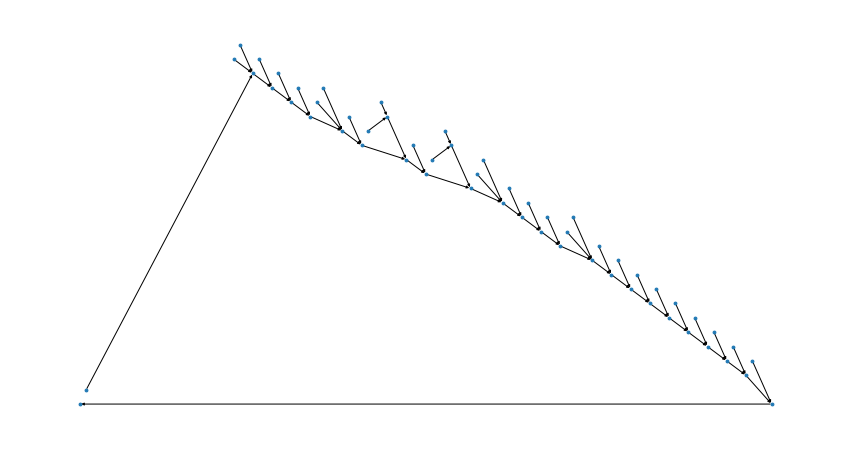

In [42]:
j=0
from matplotlib import cm
cmap=cm.get_cmap(name='magma')
fig,ax=plt.subplots(figsize=(15,8))
d=dat[j]
d.num_nodes=dat[j].x.shape[0]
G=tg.utils.to_networkx(d)
di=nx.betweenness_centrality(G)
for q,key in enumerate(di.keys()):
    di[key]=dat[j].x.numpy()[q,2]
nx.set_node_attributes(G, di, 'n_prog')
print('Made graph')
# G.remove_nodes_from(list(nx.isolates(G)))
pos=nx.planar_layout(G)
# pos=nx.kamada_kawai_layout(G) #this one is kinda snakey but works pretty well! Slow as hell though
if G.number_of_nodes()<2000:
    print('drawing')
    nx.draw(G, pos=pos,ax=ax, node_size=8, arrowsize=5, cmap=cmap)

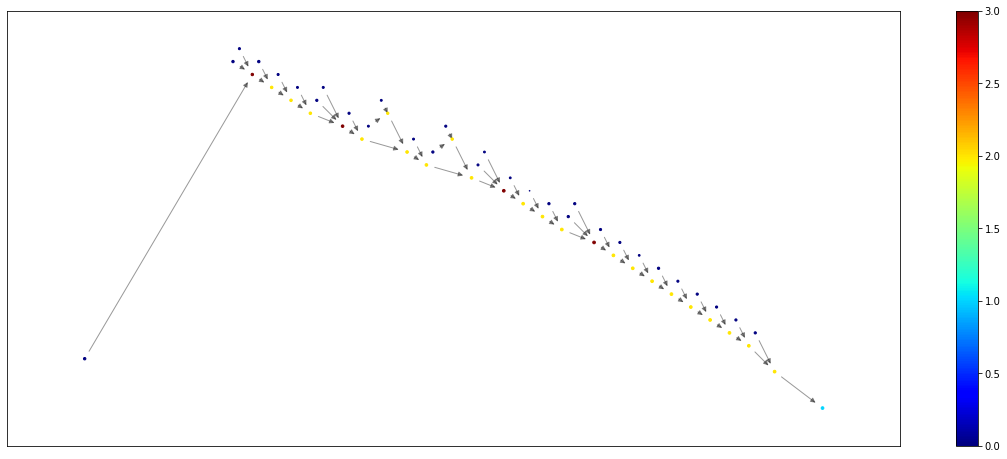

In [41]:
import matplotlib.pyplot as plt
# create number for each group to allow use of colormap
from itertools import count
fig,ax=plt.subplots(figsize=(20,8))
# get unique groups
groups = set(nx.get_node_attributes(G,'n_prog').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors=dat[j].x.numpy()[:,2]
sizes=(dat[j].x.numpy()[:,3]-min(dat[j].x.numpy()[:,3])+2)**2/10
# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.planar_layout(G)
pos[min(pos.keys())]=(pos[min(pos.keys())]*np.array([-0.75,1.1]))*1.1
# pos[max(pos.keys())]=pos[max(pos.keys())]*np.array([0.9,-0.9])
ec = nx.draw_networkx_edges(G, pos,arrowsize=10, ax=ax, alpha=0.4)
nc = nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=nodes, node_color=colors, node_size=sizes, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [24]:
pos[min(pos.keys())]=pos[min(pos.keys())]*np.array([0.9,-0.9])
pos[max(pos.keys())]=pos[max(pos.keys())]*np.array([-0.9,0.9])

In [45]:
dat[j].x.numpy()[:,0]

array([ 5.1993375 ,  2.5117912 ,  2.2899878 ,  1.792374  ,  1.6896701 ,
        1.5417962 ,  1.521525  ,  1.4752693 ,  1.4532796 ,  1.4319708 ,
        1.1844468 ,  1.1570615 ,  0.77483284,  0.7364425 ,  0.69431055,
        0.3884302 ,  0.324254  ,  0.2536062 ,  0.04643572, -0.44453385,
       -0.5642668 , -0.75466424, -0.97748655, -1.1047469 ,  0.18547964,
       -0.11315218, -1.5542696 , -1.3620783 , -1.8050231 , -2.183092  ,
       -1.5542696 , -1.1047469 , -0.8625437 , -1.1047469 , -0.5642668 ,
       -1.1047469 , -0.11315218, -0.5642668 , -1.5542696 , -0.6642872 ,
       -0.03387984, -0.8625437 , -0.44453385, -0.5642668 , -0.5642668 ,
        0.324254  ,  0.45424896,  1.3310177 , -1.1047469 , -0.2769978 ,
        1.4532796 ,  1.0685216 ,  1.5843543 ,  1.0685216 ,  2.1440108 ,
        1.9264032 ], dtype=float32)

In [ ]:
xs=[]
ls=[]
ys=[]
for d in dat:
    xs.append(d.x.numpy())
    ys.append(d.y.numpy())
    ls.append(len(d.x.numpy()))
xs=np.vstack(xs)

array([ 34. , 235.2])

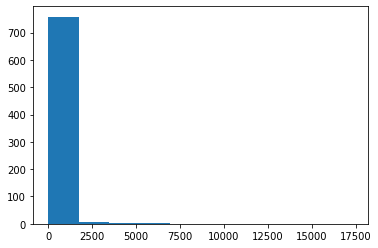

In [135]:
plt.hist(ls)
np.quantile(ls, [0.25,0.9])

In [60]:
plt.plot(ls,ys)

NameError: name 'ls' is not defined